In [1]:
%load_ext autoreload
%autoreload 2
from notebook_utils import *

# PLOTTING
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
    #"text.usetex": True,
    "font.family": "serif",
    'font.size':16,
    "lines.linewidth":3.0,
    "savefig.dpi":500,
    'text.latex.preamble':r'\boldmath'
})
plt.rc('axes', grid=True)
cmap=plt.cm.Spectral_r
savedir= '/private/home/sdascoli/recur/figs/'
if not os.path.exists(savedir):
    os.mkdir(savedir)

# Runs

In [2]:
#1631806670 reals
#1632144149 scheduling
#1632300019 precision and nbops
#1632346714 integers
#1632847796 stochasticity
#1633017397 enc/dec hparams
#1633091904 precision and int_base
#1633105818 long run
#1633702046 multidim NEW

runs = []
logs = []
numbers = [1632300019]
numbers = [-1]
base = '/checkpoint/sdascoli/recur/'
numbers = [None]
base = '/checkpoint/pakamienny/recur/paper/base'
#base = '/checkpoint/sdascoli/recur/final/base'
#base = '/checkpoint/pakamienny/recur/final/multidim'
numbers = [(base, num) for num in numbers]

NaN = np.nan
Infinity = np.nan

for (base, num) in numbers:

    if num is None: path = base
    elif num<100:
        paths = sorted(glob.glob(base+'*'), key=(lambda x : x.split('/')[-1]))
        paths=[p for p in paths if os.path.isdir(p) and p[-1].isdigit()]
        print(paths)
        path = paths[num]
    else:
        path = base+str(num)
    path += '/'
    print(path)

    dirnames = glob.glob(path+'*')
    dirnames = [p for p in dirnames if (os.path.isdir(p) and not p.endswith('__'))]
    print('{} runs found'.format(len(dirnames)))
    fails = 0
    for dirname in dirnames:
        if dirname.endswith('src'): continue
        if len(dirnames)<1000: print(dirname)
        try : 
            run = {}
            args = pickle.load(open(dirname+'/params.pkl', 'rb'))
            run['args'] = args
            run['logs'] = []
            run['num_params'] = []
            f = open(dirname+'/train.log', "r")
            for line in f.readlines():
                if '__log__' in line:
                    run['logs'].append(eval(line[line.find('{'):].rstrip('\n')))
                elif '(encoder)' in line:
                    run['num_params_enc'] = eval(line.split(' ')[-1].rstrip('\n'))
                elif '(decoder)' in line:
                    run['num_params_dec'] = eval(line.split(' ')[-1].rstrip('\n'))
            f.close()
            run['num_params'] = run['num_params_enc']+run['num_params_dec']
            args.output_dir = Path(dirname)
            runs.append(run)
        except Exception as e: 
            print(e)
            print('failed !'.format(dirname))
            fails += 1
    print('{} fails'.format(fails))
    
latest = min([len(run['logs']) for run in runs])-1
print('latest : ',latest)
params = defaultdict(list)
for run in runs:
    for k,v in vars(run['args']).items():
        params[k].append(v)
for k in params:
    try: params[k] = sorted(list(set(params[k])))
    except: pass

/checkpoint/pakamienny/recur/paper/base/
4 runs found
/checkpoint/pakamienny/recur/paper/base/float_sequences_True_output_numeric_True_dimension_1_prob_rand_0.0_batch_size_64_optimizer_adam_inverse_sqrt,lr=0.0002
/checkpoint/pakamienny/recur/paper/base/float_sequences_True_output_numeric_False_dimension_1_prob_rand_0.0_batch_size_64_optimizer_adam_inverse_sqrt,lr=0.0002
/checkpoint/pakamienny/recur/paper/base/float_sequences_False_output_numeric_True_dimension_1_prob_rand_0.0_batch_size_64_optimizer_adam_inverse_sqrt,lr=0.0002
/checkpoint/pakamienny/recur/paper/base/float_sequences_False_output_numeric_False_dimension_1_prob_rand_0.0_batch_size_64_optimizer_adam_inverse_sqrt,lr=0.0002
0 fails
latest :  61


# Performance

2
float_sequences_False_output_numeric_True_dimension_1_prob_rand_0.0_batch_size_64_optimizer_adam_inverse_sqrt,lr=0.0002 73308955 62 64.84
float_sequences_False_output_numeric_False_dimension_1_prob_rand_0.0_batch_size_64_optimizer_adam_inverse_sqrt,lr=0.0002 68197423 101 74.67


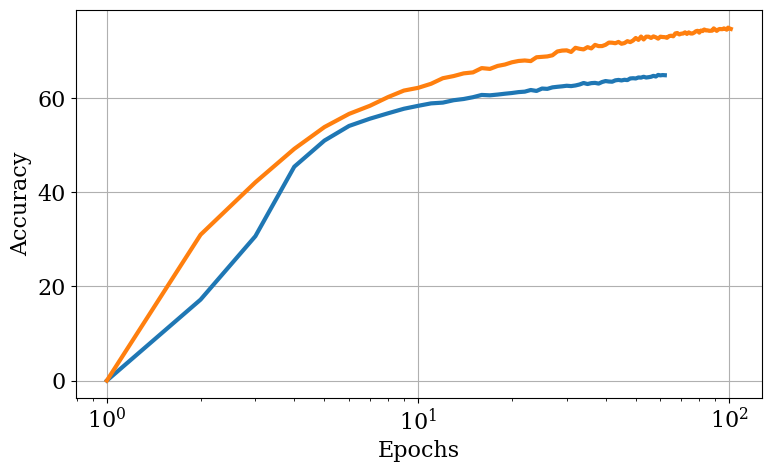

In [3]:
constraints = {
    'float_sequences':False,
    #'real_series':True,
    #'dimension':[1,2],
    #'prob_rand':0.05
    #'n_enc_layers':4,
    #'n_dec_layers':4,  
    #'prob_rand':0.0,
    #'curriculum_n_ops':False,
    #'optimizer':"adam_inverse_sqrt,lr=0.0006"
}
selected_runs, selected_params = select_runs(runs, params, constraints)
#selected_runs = selected_runs[::-1]

plt.figure(figsize=(8,5))
print(len(selected_runs))
for run in selected_runs[:]:
    args = run['args']
    #if 'warmup' not in args.optimizer: continue
    latest = len(run['logs'])
    loss       = [run['logs'][t]['valid1_recurrence_xe_loss'] for t in range(latest)]
    perfect    = [run['logs'][t]['valid1_recurrence_perfect'] for t in range(latest)]
    valid      = [run['logs'][t]['valid1_recurrence_beam_acc'] for t in range(latest)]
    additional = [run['logs'][t]['valid1_recurrence_additional_1'] for t in range(latest)]
    if valid: print(Path(args.dump_path).name, run['num_params'], latest, valid[-1])
    label = Path(args.dump_path).name
    #label = 'dim {}'.format(lab)
    plt.plot(range(1,len(valid)+1), valid, label=label)

#plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xscale('log')

plt.tight_layout()
plt.show()

64.8 & 65.7 & 67.1
74.7 & 76.2 & 77.1
76.6 & 63.1
89.0 & 72.5


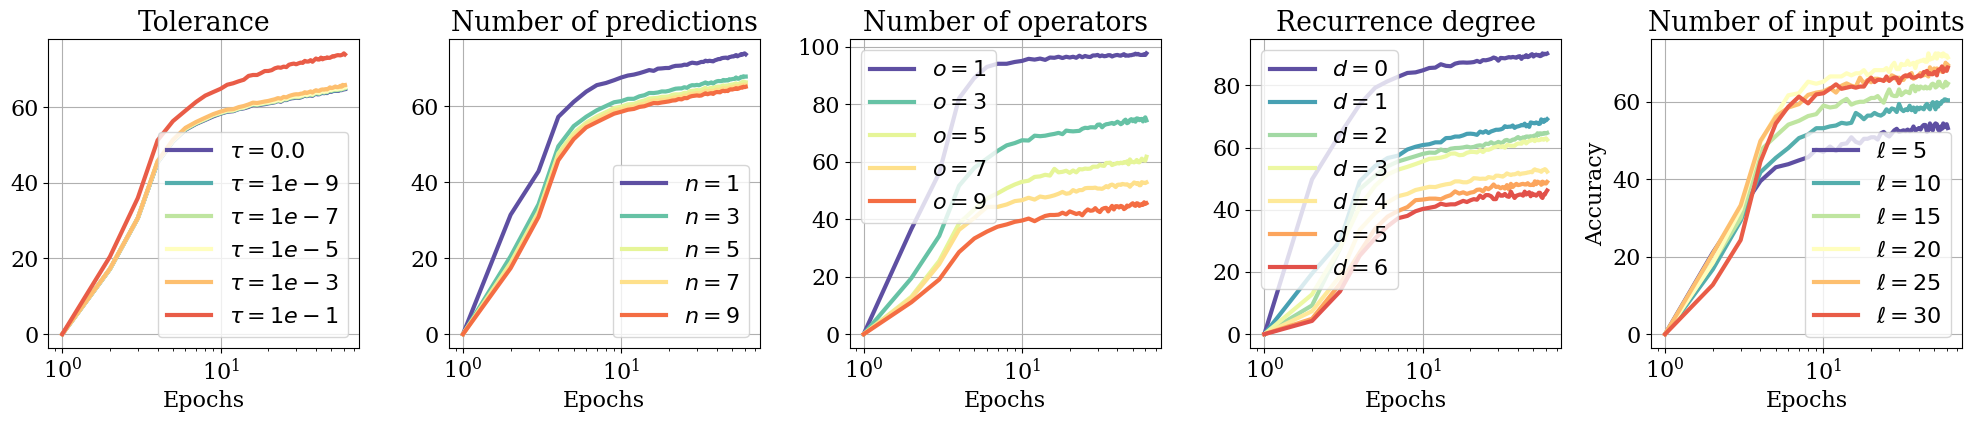

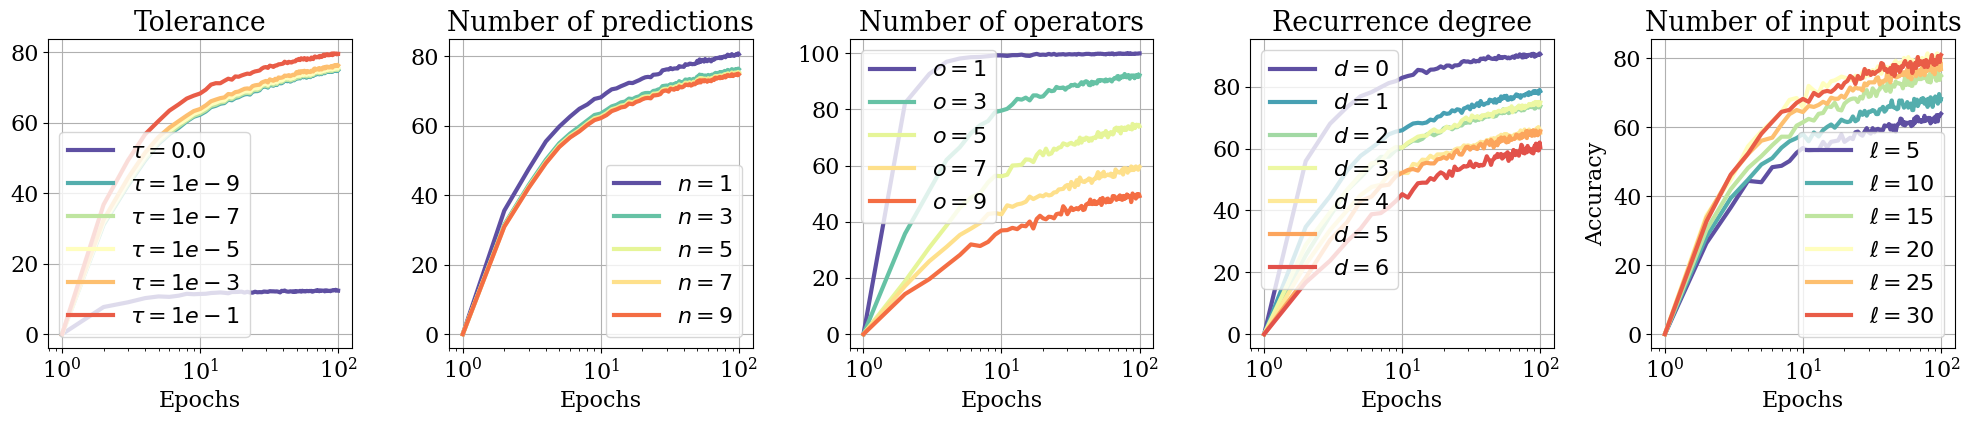

64.71
additional [64.84, 64.88, 64.95, 65.02, 65.12, 65.24, 65.42, 65.69, 67.12, 73.86]
n_predictions [73.46, 69.58, 67.88, 67.05, 66.37, 65.99, 65.68, 65.33, 65.15, 64.84]
ops [97.37793851717902, 85.51842330762639, 75.22123893805309, 64.05109489051095, 60.86142322097378, 56.30165289256198, 52.87234042553192, 49.10820451843044, 45.07361268403171, 44.19475655430712]
deg [90.20979020979021, 68.61673045379989, 65.06276150627615, 62.79329608938548, 52.19298245614035, 48.83720930232558, 45.45454545454545]
points_averaged [55.30328422215741, 61.68507200882397, 62.45782084688011, 70.78562536751747, 70.06789394036673, 70.48381057757716, 69.38775510204081]
12.62
additional [74.67, 74.83, 74.93, 75.06, 75.23, 75.47, 75.78, 76.15, 77.08, 79.72]
n_predictions [80.59, 77.3, 76.3, 75.78, 75.35, 75.11, 74.95, 74.84, 74.75, 74.67]
ops [99.81916817359856, 97.77206512425022, 92.30088495575221, 81.02189781021897, 73.97003745318352, 67.97520661157024, 58.829787234042556, 53.62663495838288, 49.377123442808

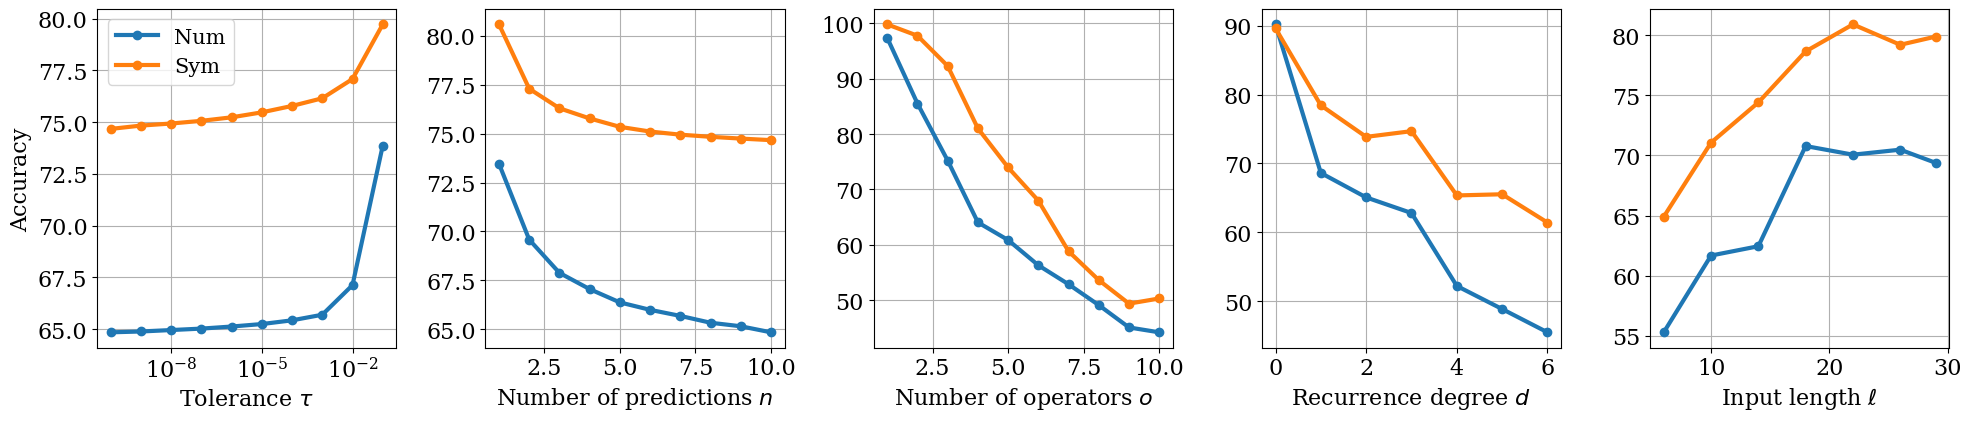

In [5]:
latest = min([len(run['logs'])-1 for run in selected_runs])
latest = -1

# chunk the inputs lens
chunk_size = 4
for run in selected_runs:
    keys = [k for k in run['logs'][0].keys() if 'points' in k]
    x = [int(k.split('_')[-1]) for k in keys]
    for length in x[::chunk_size]:
        lengths = range(length, min(max(x),length+chunk_size))
        if not lengths: continue
        keys_to_average = [f'valid1_recurrence_beam_acc_n_input_points_{l}' for l in lengths]
        average_acc =  np.mean([run['logs'][latest][k] for k in keys_to_average])
        run['logs'][latest][f'valid1_recurrence_beam_acc_n_input_points_averaged_{int(np.mean(lengths))}'] =  average_acc
        
keys = ['valid1_recurrence_additional_2', 'valid1_recurrence_additional_9', 'valid1_recurrence_additional_10']
for run in selected_runs:
    print(' & '.join(['{:.1f}'.format(run['logs'][latest][key]) for key in keys]))

key_list = [['valid1_recurrence_beam_acc_n_ops_{}'.format(i) for i in range(1,6)], ['valid1_recurrence_beam_acc_n_ops_{}'.format(i) for i in range(1,11)]]
for run in selected_runs:
    accs = []
    for keys in key_list:
        accs.append(np.mean([run['logs'][latest][key] for key in keys]))
    print(' & '.join(['{:.1f}'.format(x) for x in accs]))
        
#########
metrics = ['additional', 'n_predictions', 'ops', 'deg', 'points']
legends = ['\\tau','n','o', 'd', '\ell']
labels = ['Tolerance', 'Number of predictions', 'Number of operators', 'Recurrence degree', 'Number of input points']

for run in selected_runs:
    args = run['args']
    fig, axarr = plt.subplots(1, len(metrics), figsize=(4*len(metrics),4.5))
    for i, metric in enumerate(metrics):
        keys = [k for k in run['logs'][0].keys() if metric in k]
        keys = keys[::max(1,len(keys)//5)]
        for j, key in enumerate(keys):
            label = int(key.split('_')[-1])
            if metric == 'additional': label = args.more_tolerance.split(',')[int(label)-1]
            acc = [run['logs'][t][key] for t in range(len(run['logs'][:latest]))]
            axarr[i].plot(range(1, len(acc)+1), acc, label='${}={}$'.format(legends[i],label), color = cmap(j/len(keys)))
        axarr[i].set_title(labels[i])
        axarr[i].legend()
    for ax in axarr:
        ax.set_xscale('log')
        ax.set_xlabel('Epochs')
    #for n, ax in enumerate(axarr):
    #    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, size=20, weight='bold')
    axarr[-1].set_ylabel('Accuracy')
    plt.tight_layout()
    plt.savefig(savedir+'acc_vs_time_{}_{}.pdf'.format('float' if args.float_sequences else 'int', 'num' if args.output_numeric else 'sym'))
    plt.show()    

##########
metrics = ['additional', 'n_predictions', 'ops', 'deg', 'points_averaged']
labels = [ 'Tolerance $\\tau$', 'Number of predictions $n$','Number of operators $o$', 'Recurrence degree $d$', 'Input length $\ell$']
        
suffix = ''
fig, axarr = plt.subplots(1, len(metrics), figsize=(4*len(metrics),4.5))
for run in selected_runs:
    args = run['args']
    run['logs'][-1]
    for i, metric in enumerate(metrics):
        if metric == 'ops':
            keys = [k for k in list(run['logs'][latest].keys())[::args.dimension] if metric in k]
        else:
            keys = [k for k in run['logs'][latest].keys() if metric in k]
        if metric == 'additional':
            keys = keys[1:]
            x = [eval(x) for x in args.more_tolerance.split(',')[1:]]
            print(run['logs'][latest]["valid1_recurrence_additional_1"])
            axarr[i].set_xscale('log')
        elif metric == 'ops':
            x = [int(k.split('_')[-1])//args.dimension for k in keys]
        #elif metric == 'points_averaged':
        #    x = [int(k.split('_')[-1])*args.dimension for k in keys]
        else:
            x = [int(k.split('_')[-1]) for k in keys]
        y = [run['logs'][latest][k] for k in keys]
        print(metric, y)
        label = 'Num' if run['args'].output_numeric else 'Sym'
        if args.prob_rand: 
            label += ' $p_{{rand}}={}$'.format(args.prob_rand)
            suffix = '_rand'
        elif args.dimension>1: 
            label += ' dim={}'.format(args.dimension)
            suffix = '_multidim'
        axarr[i].plot(x, y, label = label, marker='o')
        axarr[i].set_xlabel(r'{}'.format(labels[i]))
        #axarr[i].set_ylim(bottom=0, top=100)
        #axarr[i].set_yscale('symlog')
#for n, ax in enumerate(axarr):
#    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, size=20, weight='bold')
axarr[0].set_ylabel('Accuracy')
axarr[0].legend(fontsize=15)
plt.tight_layout()
title = 'acc_vs_difficulty_{}'.format('float' if args.float_sequences else 'int') + suffix + '.pdf'
plt.savefig(savedir+title)
plt.show()    

# Evaluate run

In [ ]:
for run in selected_runs:
    
    res = {}
    
    for group, ops in id_groups.items():
        
        args = run['args']
        new_args = copy.deepcopy(args)
        new_args.eval_size = 128
        new_args.batch_size_eval = 1000
        new_args.more_tolerance = '1e-10,0.001,0.01'
        #new_args.max_ops = 5
        #new_args.float_constants = None
        #new_args.eval_noise = 0.0
        #new_args.eval_noise_type = 'additive'
        
        new_args.extra_unary_operators = 'id'
        new_args.operators_to_remove = ','.join(set(all_ops)-set(id_groups['base']+ops))
        
        #new_args.operators_to_remove = ','.join(set(all_ops)-set(id_groups['base']))
        #new_args.extra_unary_operators = ','.join(ops)
        
        
        scores = eval_run(run, new_args)
        print(new_args.operators_to_remove, ' & '.join(['{:.1f}'.format(scores['valid1_recurrence_additional_'+str(i)]) for i in range(1,4)]))
        res[group] = scores['valid1_recurrence_additional_1']

    print(res)

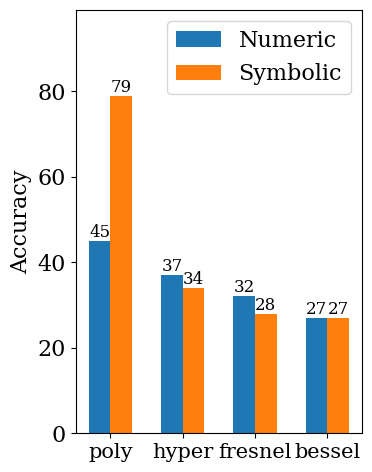

In [21]:
perfs_num = {'base': 41.40625, 'div': 33.59375, 'abs': 40.625, 'sqrt': 42.1875, 'exp': 47.65625, 'trig': 36.71875}
perfs_sym = {'base': 64.84375, 'div': 60.9375, 'abs': 62.5, 'sqrt': 64.84375, 'exp': 60.9375, 'trig': 50.0}
perfs_num = {'poly': 44.53125, 'hyper': 36.71875, 'fresnel': 32.03125, 'bessel': 26.5625}
perfs_sym = {'poly': 78.90625, 'hyper': 33.59375, 'fresnel': 28.125, 'bessel': 27.34375}


labels = perfs_num.keys()
x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(4,5))
rects1 = ax.bar(x - width/2, [round(x) for x in perfs_num.values()], width, label='Numeric')
rects2 = ax.bar(x + width/2, [round(x) for x in perfs_sym.values()], width, label='Symbolic')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=0, fontsize=15)
ax.bar_label(rects1, fontsize=12, rotation=0)
ax.bar_label(rects2, fontsize=12, rotation=0)
ax.set_ylim(top=max(list(rects1.datavalues)+list(rects2.datavalues))+20)
ax.legend()
ax.grid(False)
fig.tight_layout()
plt.savefig(savedir+'acc_vs_group_{}.pdf'.format('id' if 'base' in perfs_num else 'ood'))
plt.show()

In [16]:
run = selected_runs[1]
      
for penalty in [0,1]:
    args = run['args']
    new_args = copy.deepcopy(args)
    new_args.eval_size = 10000
    new_args.batch_size_eval = 128
    new_args.more_tolerance = '1e-10,0.001,0.01'
    new_args.min_len=30
    new_args.beam_length_penalty=penalty

    scores = eval_run(run, new_args)
    print(' & '.join(['{:.1f}'.format(scores['valid1_recurrence_additional_'+str(i)]) for i in range(1,4)]))
    print(scores)

Reloading checkpoint from /checkpoint/sdascoli/recur/final/base/float_sequences_True_output_numeric_False_dimension_1_prob_rand_0.0_batch_size_64_optimizer_adam_inverse_sqrt,lr=0.0006/checkpoint.pth ...
Reloading checkpoint optimizer ...
Checkpoint reloaded. Resuming at epoch 111 / iteration 520368 ...


44.7 & 53.3 & 59.8
OrderedDict([('epoch', 111), ('valid1_recurrence_xe_loss', 15.591899960756303), ('valid1_recurrence_perfect', 16.33), ('valid1_recurrence_correct', 99.88), ('valid1_recurrence_beam_acc', 44.72), ('valid1_recurrence_additional_1', 44.72), ('valid1_recurrence_additional_2', 53.28), ('valid1_recurrence_additional_3', 59.79), ('valid1_recurrence_beam_acc_n_predictions_1', 45.1), ('valid1_recurrence_beam_acc_n_predictions_2', 44.83), ('valid1_recurrence_beam_acc_n_predictions_3', 44.75), ('valid1_recurrence_beam_acc_n_predictions_4', 44.72), ('valid1_recurrence_beam_acc_n_predictions_5', 44.72), ('valid1_recurrence_beam_acc_n_input_points_30', 44.72), ('valid1_recurrence_beam_acc_n_ops_1', 99.6244131455399), ('valid1_recurrence_beam_acc_n_ops_2', 94.5748987854251), ('valid1_recurrence_beam_acc_n_ops_3', 74.5003996802558), ('valid1_recurrence_beam_acc_n_ops_4', 46.22980251346499), ('valid1_recurrence_beam_acc_n_ops_5', 27.868852459016395), ('valid1_recurrence_beam_acc_n_op

Reloading checkpoint from /checkpoint/sdascoli/recur/final/base/float_sequences_True_output_numeric_False_dimension_1_prob_rand_0.0_batch_size_64_optimizer_adam_inverse_sqrt,lr=0.0006/checkpoint.pth ...
Reloading checkpoint optimizer ...
Checkpoint reloaded. Resuming at epoch 111 / iteration 520368 ...


44.7 & 53.3 & 59.8
OrderedDict([('epoch', 111), ('valid1_recurrence_xe_loss', 15.591899960756303), ('valid1_recurrence_perfect', 16.33), ('valid1_recurrence_correct', 99.88), ('valid1_recurrence_beam_acc', 44.72), ('valid1_recurrence_additional_1', 44.72), ('valid1_recurrence_additional_2', 53.28), ('valid1_recurrence_additional_3', 59.79), ('valid1_recurrence_beam_acc_n_predictions_1', 45.1), ('valid1_recurrence_beam_acc_n_predictions_2', 44.83), ('valid1_recurrence_beam_acc_n_predictions_3', 44.75), ('valid1_recurrence_beam_acc_n_predictions_4', 44.72), ('valid1_recurrence_beam_acc_n_predictions_5', 44.72), ('valid1_recurrence_beam_acc_n_input_points_30', 44.72), ('valid1_recurrence_beam_acc_n_ops_1', 99.6244131455399), ('valid1_recurrence_beam_acc_n_ops_2', 94.5748987854251), ('valid1_recurrence_beam_acc_n_ops_3', 74.5003996802558), ('valid1_recurrence_beam_acc_n_ops_4', 46.22980251346499), ('valid1_recurrence_beam_acc_n_ops_5', 27.868852459016395), ('valid1_recurrence_beam_acc_n_op

# In distribution

In [ ]:
n = 3
failure_only = False
use_sympy = False

run = selected_runs[1]
env, modules, trainer, evaluator = load_run(run)
encoder, decoder = modules["encoder"], modules["decoder"]
args = run['args']
    
fig, axarr = plt.subplots(n,n,figsize=(n*3,n*3))
n_errors = 0
for i in range(n):
    for j in range(n):
        while True:
            try:
                tree, pred_tree, series, preds, score = predict(args, gen_kwargs={'nb_ops':2, 'length':25})
                if args.prob_rand and "rand" not in tree.prefix(): continue
                print(i,j)
                if np.isnan(np.sum(series)) or np.isnan(np.sum(preds)): continue
                ending = np.array(series[-5:]); gaps = abs(ending[1:]-ending[:-1])
                if len(set(gaps))<2: continue # discard uninteresting series                            
                if failure_only is None: pass
                elif failure_only:
                    if abs((series[-1]-preds[-1])/series[-1])<0.1: continue
                else: 
                    if abs((series[-1]-preds[-1])/series[-1])>1e-2: continue

                confidence = 10**score
                if use_sympy: 
                    pred, true = sympy_infix(pred_tree), sympy_infix(tree)
                else:
                    pred, true = readable_infix(pred_tree), readable_infix(tree)
                #axarr[i,j].plot(series)
                #axarr[i,j].plot(preds, ls='--')
                length = len(series)//args.dimension
                axarr[i,j].axvspan(0, length//2, alpha=0.1, color='green')
                axarr[i,j].axvspan(length//2, len(series)//args.dimension, alpha=0.1, color='red')
                for dim in range(args.dimension):
                    axarr[i,j].plot(range(length), series[dim::args.dimension], color='C%d'%dim, lw=2, label='True' if dim==0 else '')
                    axarr[i,j].plot(range(length//2, length), preds[dim::args.dimension][length//2:], color='C%d'%dim, lw=8, alpha=.5, label='Pred' if dim==0 else '')
                break
            except Exception as e:
                print(e, end=' ')
                #if n_errors>1000: break
                n_errors += 1
        axarr[i,j].set_title(f'True: {true}\nPred: {pred}\nConfidence: {confidence:.2}', fontsize=10)
        #axarr[i,j].set_yscale('symlog')
        #axarr[i,j].set_xticks([])
        axarr[i,j].set_yticks([])    
axarr[-1,-1].legend(fontsize=12)
        
plt.tight_layout()
title = 'failure' if failure_only else 'success'
title += '_{}'.format('float' if args.float_sequences else 'int', args.dimension)
if args.prob_rand: 
    title += '_rand'
elif args.dimension>1: 
    suffix += '_multidim'
title += '.pdf'
plt.savefig(savedir+title)
plt.show()

# Out of distribution

log((n + (n - (1/(n) / n))))
log((n + (n - 1/((n * n)))))
log((n + (n + (-1 / (n + n)))))
log((n + (n - (1/(n) / n))))
4.787422291102689 4.787489427964552
-1.4023593027826955e-05


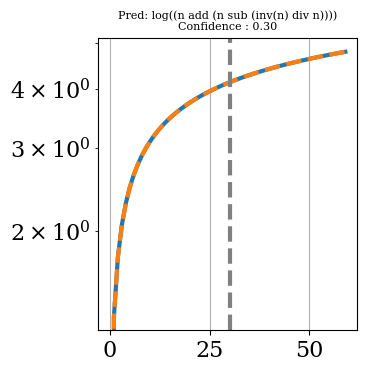

In [209]:
run = selected_runs[1]
env, modules, trainer, evaluator = load_run(run)
encoder, decoder = modules["encoder"], modules["decoder"]
args = run['args']

from scipy.special import erf, factorial
f = lambda n : scipy.special.dawsn(n)
f = lambda n : np.arctanh(1/(n+1))
f = lambda n : np.arccosh(n)
# np.exp(np.pi*np.sqrt(2*n/3))/(4*n*np.sqrt(3))
length = 30
pred_len = 30

fig, ax = plt.subplots(1,1,figsize=(4,4))
series = [f(n) for n in range(1,length+pred_len+1)]
#series = [logistic(n, 3, 0.5) for n in range(length)]

tree, pred, _, preds, score = predict(args, series=series[:length], beam_length_penalty=None, beam_size=3, verbose=True, pred_len=pred_len)
print(readable_infix(pred))
print(series[-1],preds[-1])
print((series[-1] - preds[-1])/series[-1])
confidence = 10**score
#pred = readable_infix(pred)
ax.semilogy(series)
ax.semilogy(preds, ls='--')
#ax.plot([n * np.log(n) for n in range(1,length+1)], ls='--')
ax.axvline(x=length, ls='--', color='grey')
plt.title(f'Pred: {pred}\nConfidence : {confidence:.2f}', fontsize=8)
#plt.yscale('symlog')
#plt.xticks([])
#plt.yticks([])

plt.tight_layout()
plt.show()

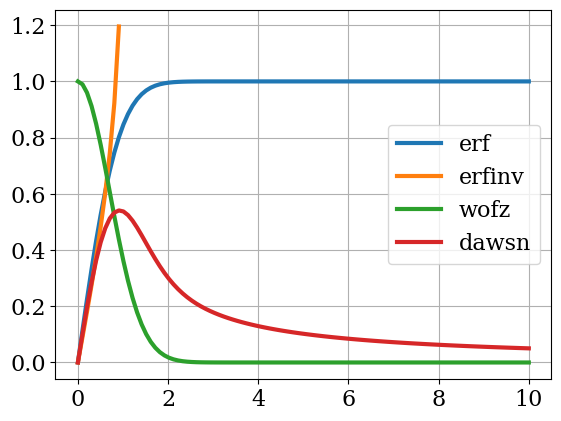

In [211]:
x = np.linspace(0,10, 100)
#plt.plot(x, np.arccosh(x))
#plt.plot(x, np.log(2*x-1/(x**1.5)))
#plt.semilogy(x, np.cosh(x))
#plt.semilogy(x, 1/np.sin(2/np.exp(x)))
for op in od_groups['fresnel']:
    if op=='fresnel': continue
    plt.plot(x, getattr(scipy.special, op)(x), label=op)
plt.legend()
plt.show()

# Embeddings

Reloading checkpoint from /checkpoint/pakamienny/recur/paper/base/float_sequences_False_output_numeric_False_dimension_1_prob_rand_0.0_batch_size_64_optimizer_adam_inverse_sqrt,lr=0.0002/checkpoint.pth ...
Reloading checkpoint optimizer ...
Checkpoint reloaded. Resuming at epoch 100 / iteration 468800 ...


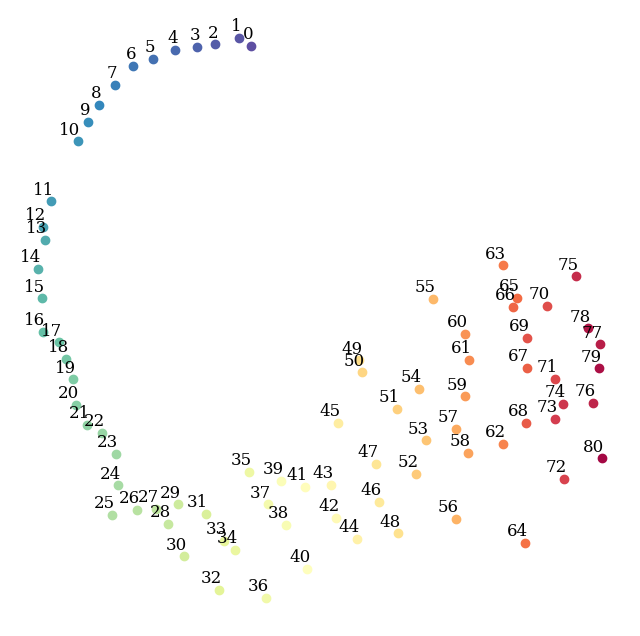

In [4]:
run = selected_runs[1]
env, modules, trainer, evaluator = load_run(run)
encoder, decoder = modules["encoder"], modules["decoder"]
args = run['args']

def get_labels_tokens(embeddings, env):
    "Creates and TSNE model and plots it"
    labels = []; tokens = []
    if args.float_sequences: smallest, largest = -50,50
    else: smallest, largest = 0, 80
    for number in range(smallest, largest+1):
        if args.float_sequences: word = 'E'+str(number-args.float_precision-1)
        else: word = str(number)
        idx = env.input_word2id[word]
        tokens.append(embeddings[idx])
        labels.append(str(number))
    return labels, tokens

def get_output_labels_tokens(embeddings, env):
    "Creates and TSNE model and plots it"
    labels = []; tokens = []
    for word, idx in env.output_word2id.items():
        tokens.append(embeddings[idx])
        labels.append(word)
    return labels, tokens
            
def tsne_plot_2d(embeddings, env, n_words=500):
    
    labels, tokens = get_labels_tokens(embeddings, env) 
    tsne_model = TSNE( n_components=2, perplexity=40, init='pca', n_iter=1000, random_state=0)
    new_values = tsne_model.fit_transform(tokens)

    x = []; y = []
    for value in new_values:
        x.append(value[0]); y.append(value[1])
        
    plt.figure(figsize=(8, 8)) 
    for i in range(len(x))[:n_words]:
        plt.scatter(x[i],y[i], color=cmap(i/min(n_words, len(x))))
        plt.annotate(labels[i], xy=(x[i], y[i]), fontsize=12, xytext=(2, 2), textcoords='offset points', ha='right', va='bottom')
    plt.axis(False)
    plt.savefig(savedir+'embeddings_{}_{}.pdf'.format('float' if args.float_sequences else 'int', 'num' if args.output_numeric else 'sym'))
    plt.show()
       
tsne_plot_2d(encoder.embeddings.weight.cpu().detach().numpy(), env)

<Figure size 1500x1500 with 0 Axes>

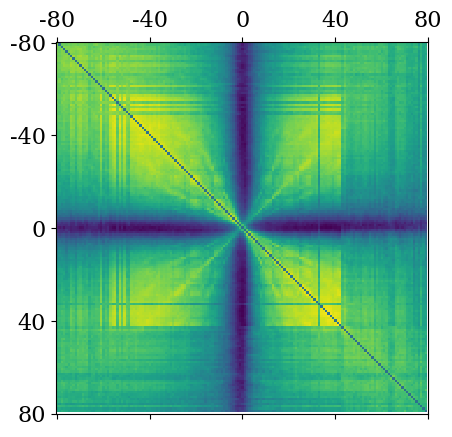

In [74]:
plt.figure(figsize=(15,15))
embeddings = encoder.embeddings.weight.cpu().detach()
if args.float_sequences: smallest, largest = -80, 80
else: smallest, largest = 0, 80
similarity = torch.zeros(largest-smallest, largest-smallest)

for i1, w1 in enumerate(range(smallest, largest)):
    if args.float_sequences: w1 = 'E'+str(w1-args.float_precision)
    for i2, w2 in enumerate(range(smallest, largest)):
        if i1==i2: continue
        if args.float_sequences: w2 = 'E'+str(w2-args.float_precision)
        j1 = env.input_word2id[str(w1)]
        j2 = env.input_word2id[str(w2)]
        similarity[i1,i2] = torch.dot(embeddings[j1], embeddings[j2])/embeddings[j1].norm()/embeddings[j2].norm()

plt.matshow(similarity)
plt.grid(False)

nticks = 5
ticks = np.linspace(0,len(similarity), nticks)
labels = np.linspace(smallest, largest, nticks).astype(int)
plt.xticks(ticks, labels)
plt.yticks(ticks, labels)

plt.tight_layout()
plt.savefig(savedir+'embedding_similarities_{}_{}.pdf'.format('float' if args.float_sequences else 'int', 'num' if args.output_numeric else 'sym'))
plt.show()

# OEIS

In [6]:
lines, ids = load_oeis()

10000 29.8506


In [17]:
batch_size = 64
max_preds = 10

run = selected_runs[0]
env, modules, trainer, evaluator = load_run(run)
encoder, decoder = modules["encoder"], modules["decoder"]
args = run['args']

print('{:.0f} batches'.format(len(lines)/batch_size))
corrects = {k:0 for k in [1,max_preds]}
tol1     = {k:0 for k in [1,max_preds]}
tol2     = {k:0 for k in [1,max_preds]}
for ibatch, batch in enumerate(chunks(lines, batch_size)):
    inputs = [seq[:-max_preds] for seq in batch]
    preds, pred_series = predict_batch(args, inputs, pred_len=max_preds)
    for i in range(len(pred_series)): 
        pred = pred_series[i]
        seq_len = len(batch[i])
        if pred is None: continue
        true = batch[i][-max_preds:]
        #print(true, pred)
        for key in corrects:
            try: 
                max_error = max([abs(float(x-y)/float(y+1e-10)) for x,y in zip(true[:key], pred[:key])])
            except Exception as e: print(e); continue
            corrects[key] += int(max_error<1e-10)
            tol1[key] += int(max_error<0.001)
            tol2[key] += int(max_error<0.01)
        
    if ibatch%10==0: 
        total = (ibatch+1)*batch_size
        print('batch {}: '.format(ibatch),
              ' '.join(['{}: {:.1f}'.format(k, 100*corrects[k]/total) for k in corrects]),
              #' '.join(['{}: {:.1f}'.format(k, 100*tol1[k]/total) for k in tol1]),
              ' '.join(['{}: {:.1f}'.format(k, 100*tol2[k]/total) for k in tol2]))

Reloading checkpoint from /checkpoint/pakamienny/recur/paper/base/float_sequences_False_output_numeric_True_dimension_1_prob_rand_0.0_batch_size_64_optimizer_adam_inverse_sqrt,lr=0.0002/checkpoint.pth ...
Reloading checkpoint optimizer ...
Checkpoint reloaded. Resuming at epoch 61 / iteration 285968 ...
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f89de628f80>
Traceback (most recent call last):
  File "/private/home/sdascoli/.conda/envs/bert/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/private/home/sdascoli/.conda/envs/bert/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/private/home/sdascoli/.conda/envs/bert/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/private/home/sdascoli/.conda/envs/bert/lib/python3.7/multiproce

156 batches
batch 0:  1: 26.6 10: 14.1 1: 32.8 10: 14.1
batch 10:  1: 29.5 10: 17.6 1: 37.8 10: 18.8
batch 20:  1: 28.3 10: 16.7 1: 39.2 10: 18.0
batch 30:  1: 37.8 10: 24.7 1: 47.8 10: 25.9
batch 40:  1: 36.6 10: 25.6 1: 45.3 10: 26.6
batch 50:  1: 36.3 10: 24.4 1: 44.9 10: 25.4
batch 60:  1: 35.6 10: 23.0 1: 43.7 10: 24.1
batch 70:  1: 36.2 10: 24.6 1: 43.6 10: 25.6
batch 80:  1: 38.7 10: 27.7 1: 45.7 10: 28.6
batch 90:  1: 38.4 10: 26.9 1: 45.7 10: 27.9
batch 100:  1: 39.6 10: 27.5 1: 46.6 10: 28.6
batch 110:  1: 40.5 10: 28.2 1: 47.3 10: 29.2
batch 120:  1: 40.2 10: 27.9 1: 47.1 10: 29.0
batch 130:  1: 40.7 10: 27.7 1: 47.6 10: 28.8
batch 140:  1: 40.1 10: 27.1 1: 47.2 10: 28.1
batch 150:  1: 39.6 10: 26.4 1: 46.8 10: 27.5


In [ ]:
def is_monotonic(seq):
    seq = np.array(seq)
    diff = seq[1:]-seq[:-1]
    if all(diff>=0) or all(diff<=0): return True
    else: return False

max_preds = 15
n_correct = 0
plot = True

for i, seq in enumerate(lines):
    #if n_correct==50: break
    if is_monotonic(seq): continue
    input_seq = seq[:-max_preds]
    _, pred, _, pred_seq, score = predict(args, series=input_seq, pred_len=max_preds)
    
    if seq[-max_preds:] != pred_seq[-max_preds:]: continue
    n_correct += 1
    print(ids[i], ', '.join(str(x) for x in input_seq[:10]), pred)
    #print(seq[-max_preds:], pred_seq[-max_preds:])
    pred = readable_infix(pred)
    
    if plot:
        plt.figure(figsize=(2,2))
        plt.plot(seq)
        plt.plot(pred_seq, ls='--')
        plt.axvline(x=len(input_seq), ls='--', color='grey')
        plt.title(f'Pred: {pred}', fontsize=8)
        plt.xticks([])
        plt.yticks([])
        plt.show()

# Attention maps

((x_0_3 div n) div (n add x_0_3))


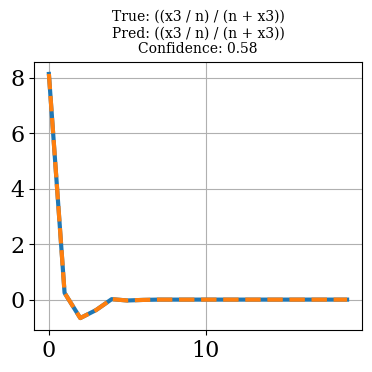

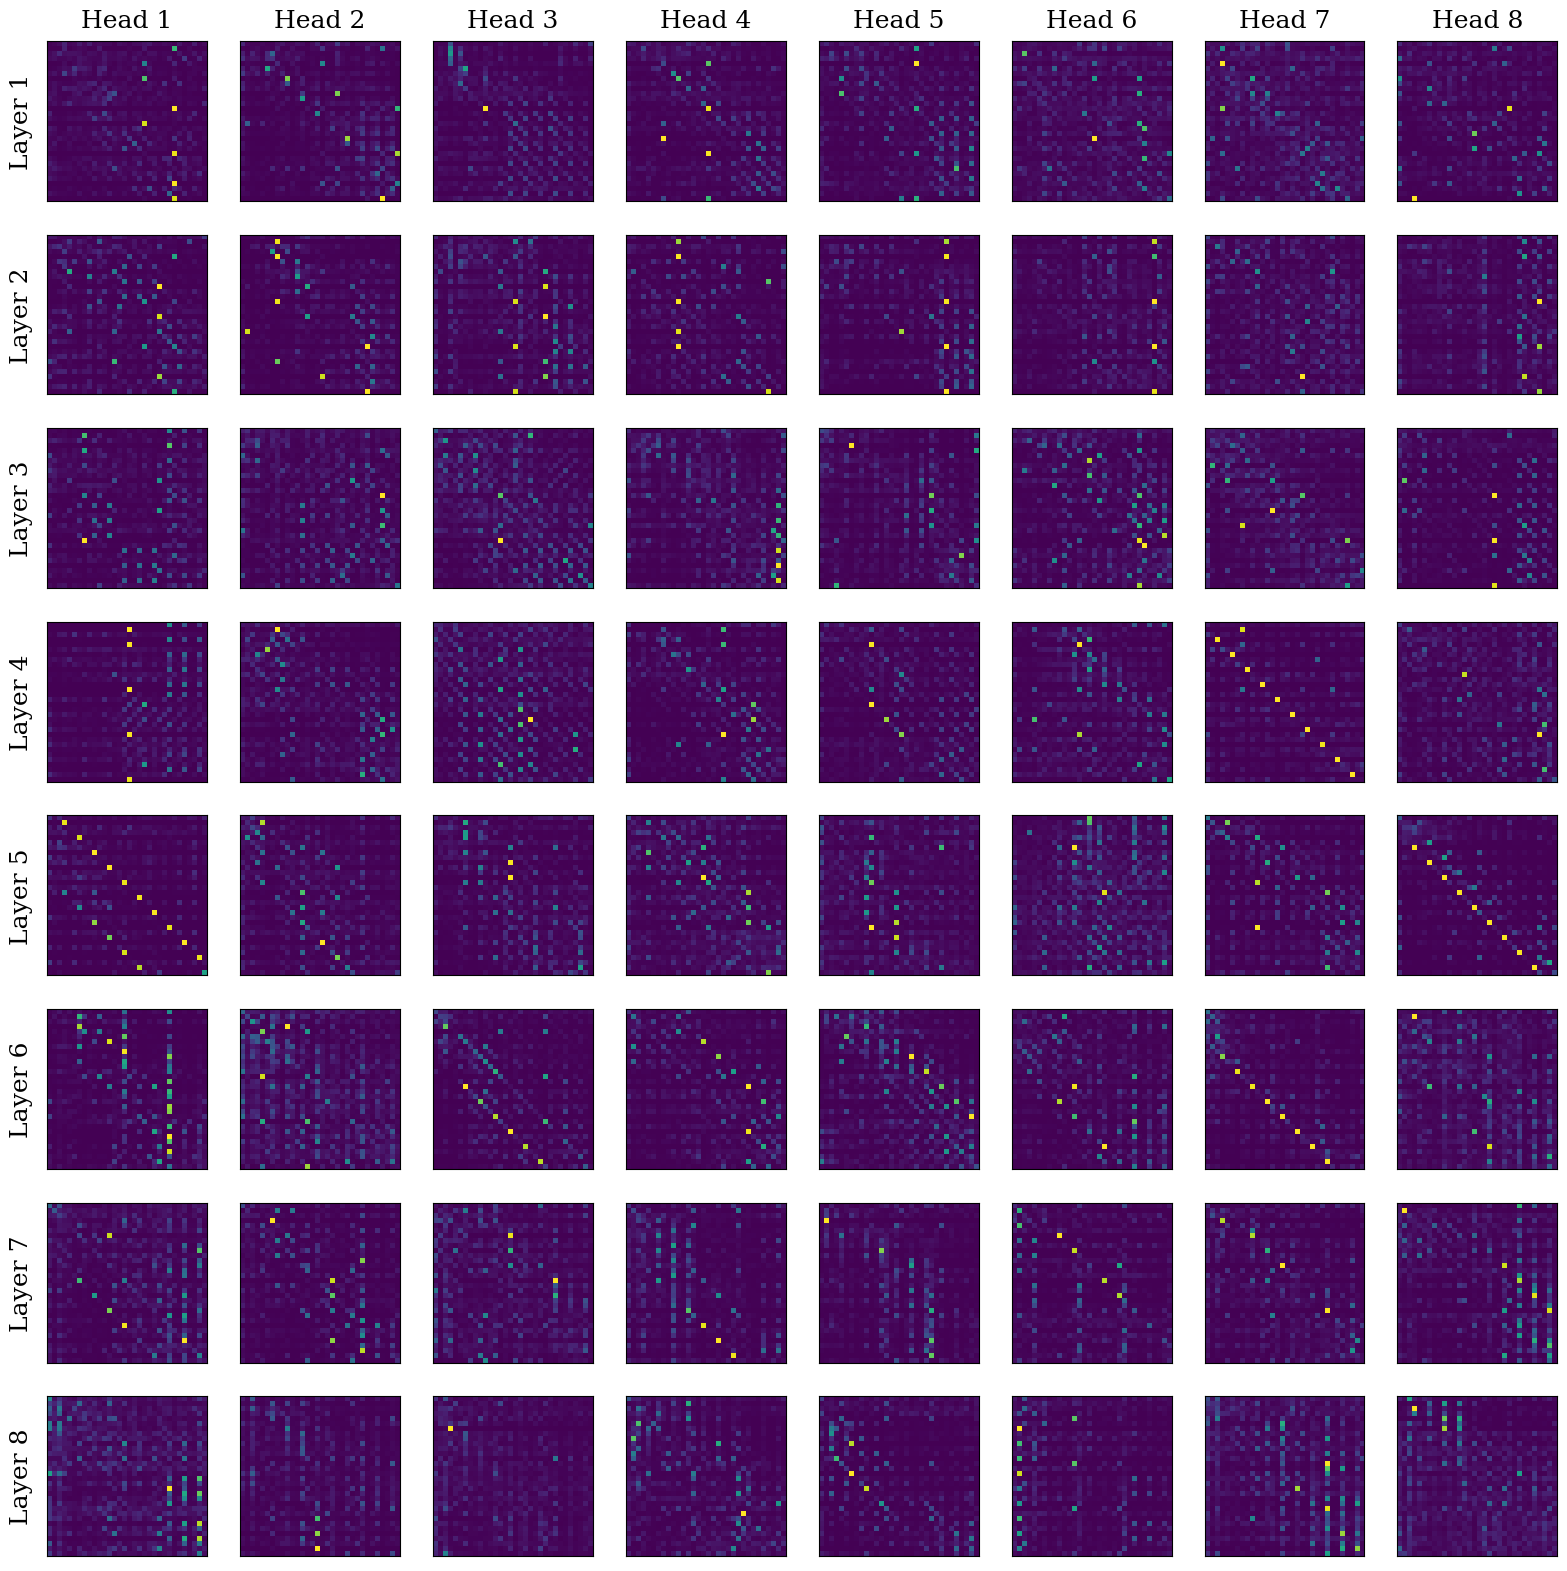

In [55]:
encoder.STORE_OUTPUTS = True

def plot_attention(model):
    
    num_heads = model.n_heads
    num_layers = model.n_layers
    
    new_args = copy.deepcopy(args)
    new_args.series_length = 15
    while True:
        #try:
        tree, pred_tree, series, preds, score = predict(new_args, kwargs={'nb_ops':3, 'deg':3, 'length':10})
        break
        #except Exception as e:
            #print(e, end=' ')
    pred, true = readable_infix(pred_tree), readable_infix(tree)
    separations = [idx for idx, val in enumerate(np.array(env.input_encoder.encode(series[:len(series)//2+1]))) if val in ['+','-']]
            
    plt.figure(figsize=(4,4))
    plt.plot(series)
    plt.plot(preds, ls='--')
    plt.title(f'True: {true}\nPred: {pred}\nConfidence: {confidence:.2}', fontsize=10)
    plt.tight_layout()
    plt.savefig(savedir+'attention_plot_{}.pdf'.format(args.real_series))
        
    fig, axarr = plt.subplots(num_layers, num_heads, figsize=(2*num_heads,2*num_layers), constrained_layout=True)        
        
    for l in range(num_layers):
        module = model.attentions[l]
        scores = module.outputs.squeeze()
        
        for head in range(num_heads):                  
            axarr[l][head].matshow(scores[head])
            
            axarr[l][head].set_xticks([]) 
            axarr[l][head].set_yticks([]) 
            #for val in separations: 
            #    axarr[l][head].axvline(val, color='red', lw=.5)
            #    axarr[l][head].axhline(val, color='red', lw=.5)
                
    cols = [r'Head {}'.format(col+1) for col in range(num_heads)]
    rows = ['Layer {}'.format(row+1) for row in range(num_layers)]
    for icol, col in enumerate(cols):
        axarr[0][icol].set_title(col, fontsize=18, pad=10)
    for irow, row in enumerate(rows):
        axarr[irow][0].set_ylabel(row, fontsize=18, labelpad=10)

    plt.tight_layout()
    plt.savefig(savedir+'attention_{}.pdf'.format(args.real_series))
    plt.show()
    
    return tree, pred_tree, series, preds, score
    
tree, pred_tree, series, preds, score = plot_attention(encoder)

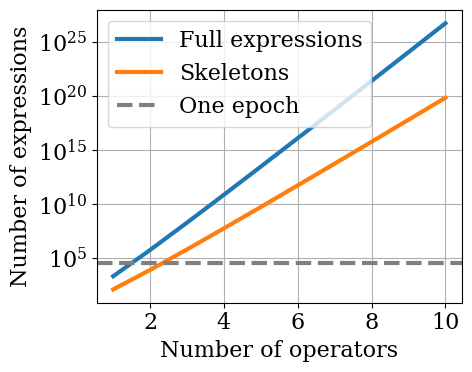

+03 & +05 & +08 & +10 & +13 & +16 & +18 & +21 & +24 & +26
+03 & +05 & +08 & +10 & +13 & +16 & +18 & +21 & +23 & +26


In [3]:
def num_trees(L, p1, p2, n):
    if n==0: return L
    elif n==1: return p2*(L*L+1)/2 + p1*L
    else: return (1/(n+1)) * ((p1+2*L*p2)*(2*n-1)*num_trees(L, p1, p2, n-1) - p1*(n-2)*num_trees(L, p1, p2, n-2))
    #else: return ((p1 + 2*L*p2)*(2*n-1)*num_trees(p1, p2, L, n-1) − p1*(n−2)*num_trees(p1, p2, L, n-2)) / (n+1)
num_trees(1, 0, 1, 5)

num_int = []
num_float = []
num_int_skeleton = []
num_float_skeleton = []
nops = range(1,11)
for nop in nops:
    num_int_skeleton.append(num_trees(6, 4, 5, nop))
    num_float_skeleton.append(num_trees(6, 12, 4, nop))
    num_int.append(num_trees(27, 4, 5, nop))
    num_float.append(num_trees(31, 12, 4, nop))
    
plt.figure(figsize=(5,4))
plt.semilogy(nops, num_int, label='Full expressions')
#plt.semilogy(nops, num_float)
plt.semilogy(nops, num_int_skeleton, label='Skeletons')
#plt.semilogy(nops, num_float_skeleton)
plt.axhline(y=3e5*1/10, color='grey',ls='--', label='One epoch')
plt.xlabel('Number of operators')
plt.ylabel('Number of expressions')
plt.legend()
plt.tight_layout()
plt.savefig(savedir+'num_expressions.pdf')
plt.show()
print(' & '.join(['{:e}'.format(_).split('e')[-1] for _ in num_int]))
print(' & '.join(['{:e}'.format(_).split('e')[-1] for _ in num_float]))